In [2]:
# # TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [4]:
grid = 32
# training data : 10,000 signal samples and 10,000 bkg samples
traindata_sig = np.load('data/jetImages_signal.npz')
traindata_bkg = np.load('data/jetImages_bkg.npz')
trainimages = np.concatenate((traindata_sig['jetImages'], traindata_bkg['jetImages']),axis=0)
print(traindata_sig['labels'])
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
# testing data : 10,000 signal samples and 10,000 bkg samples
testdata_sig = np.load('data/jetImages_signal_test.npz')
testdata_bkg = np.load('data/jetImages_bkg_test.npz')
testimages = np.concatenate((testdata_sig['jetImages'], testdata_bkg['jetImages']),axis=0)
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)
trainradii = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
traintheta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
testradii = np.concatenate((testdata_sig['radiilab'], testdata_bkg['radiilab']), axis = 0)
test_theta = np.concatenate((testdata_sig['thetalab'], testdata_bkg['thetalab']), axis = 0)
trainz = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
testz = np.concatenate((testdata_sig['zlab'], testdata_bkg['zlab']), axis = 0)
n_train = len(trainlabels)
n_test = len(testlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
testimages = testimages.reshape(n_test, grid, grid, 1)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


Print a plot of data to see what it looks like!

Preprocessing -> spit data into training and testing; take 80% for training and 20% for testing.

If using CNN, uncomment ".reshape(n_data, grid, grid, 1)".

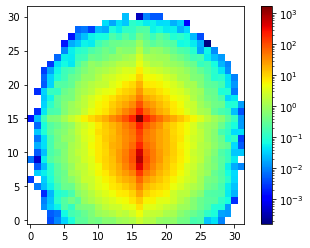

In [4]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
display_sig = sig_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

Build DNN:

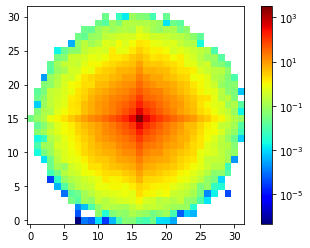

In [5]:
#background
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

In [10]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1))
    x = layers.Conv2D(32, (11, 11), activation='relu')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    input2 = layers.Input(shape=(1,))
    input3 = layers.Input(shape=(2,))
    input4 = layers.Input(shape=(1,))
    x = layers.concatenate(inputs = [x1, input2, input3, input4],axis=-1)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [11]:
circleCNN = build_model()

Test model's prediction $before$ training:

In [12]:
example_batch = trainimages[:10]
example_labels = trainlabels[:10]
example_radii = trainradii[:10]
example_theta = traintheta[:10]
example_z = trainz[:10]
example_result = circleCNN.predict(x = [example_batch, example_theta, example_radii, example_z])
results = circleCNN.evaluate(x = [example_batch, example_theta, example_radii, example_z], y = example_labels)
print(example_result)
print(results)

10/10 [==============================] - 0s 5ms/step
[[0.4974166 ]
 [0.4960576 ]
 [0.50016046]
 [0.49812865]
 [0.4976914 ]
 [0.49679002]
 [0.4972891 ]
 [0.49749863]
 [0.49845412]
 [0.4967384 ]]
[0.6979158520698547, 0.6979158520698547, 0.10000000149011612]


Now train! (warning: if building CNN, computer tends to get loud)

In [13]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
    
checkpoint_path = "model/CNN_cat_multi_input.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = circleCNN.fit(
  [trainimages, traintheta, trainradii, trainz], trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.00505, saving model to model/CNN_cat_multi_input.h5

Epoch 00002: val_loss did not improve from 0.00505

Epoch 00003: val_loss improved from 0.00505 to 0.00070, saving model to model/CNN_cat_multi_input.h5

Epoch 00004: val_loss improved from 0.00070 to 0.00037, saving model to model/CNN_cat_multi_input.h5

Epoch 00005: val_loss did not improve from 0.00037

Epoch 00006: val_loss did not improve from 0.00037

Epoch 00007: val_loss improved from 0.00037 to 0.00005, saving model to model/CNN_cat_multi_input.h5

Epoch 00008: val_loss did not improve from 0.00005

Epoch 00009: val_loss improved from 0.00005 to 0.00003, saving model to model/CNN_cat_multi_input.h5

Epoch 00010: val_loss did not improve from 0.00003

Epoch 00011: val_loss improved from 0.00003 to 0.00002, saving model to model/CNN_cat_multi_input.h5

Epoch 00012: val_loss did not improve from 0.00002

Epoch 00013: val_loss improved 

Now make a plot that shows the pregression of accuracy through each training epoch.

In [14]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['binary'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,100])
#   plt.legend()
#   plt.show()

# plot_history(history)

Load best weights.

In [15]:
!ls model
best_model = keras.models.load_model('model/CNN_cat_multi_input.h5')
best_model.summary()
results = best_model.evaluate([testimages, test_theta, testradii, testz], testlabels)
print(results)

4MLP.h5			CNN_test.h5			  RNN_4GRU.h5
CNN_cat_multi_input.h5	RNN_1dense_4GRU.h5		  RNN_5GRU.h5
CNN_class_leakyrelu.h5	RNN_2x2048_2x512_1batchrenorm.h5  RNN.h5
CNN_sparce_cat.h5	RNN_4GRU_gradclip.h5		  RNN_jetqandml.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 22, 22, 32)   3904        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 20, 20, 32)   9248        conv2d_5[0][0]                   
_________________________________________________________________________________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

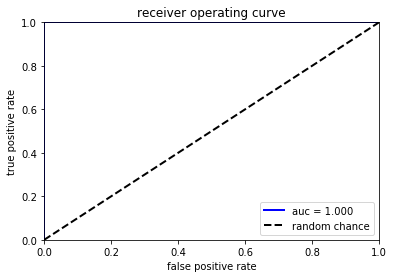

In [16]:
# Plot ROC
predict = best_model.predict([testimages, test_theta, testradii, testz])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

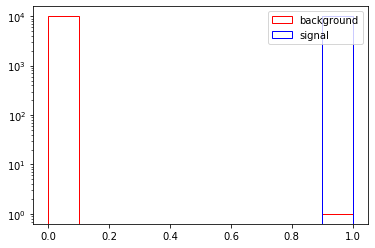

In [17]:
hist, bin_edges = np.histogram(predict[:int(len(predict)/2)])
hist_, bin_edges_ = np.histogram(predict[:-int(len((predict)-1)/2)])
plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2)-1:-1].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.legend()
plt.yscale('log')
plt.show()